# Correlations within genes

In [6]:
# we will be using a data handling library called pandas
# which is basically a python spreadsheet

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline


# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

## From last time

In [200]:
# annotation file from NCBI
annot = pd.read_csv("~/Downloads/E_coli_K12_ProteinTable167_161521.txt",sep='\t')
annot.head(10)

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX
5,chr,NC_000913.3,5683,6459,-,944749,yaaA,b0006,NP_414547.1,258,-,peroxide stress resistance protein YaaA
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B
8,chr,NC_000913.3,9306,9893,+,944760,mog,b0009,NP_414550.1,195,-,molybdopterin adenylyltransferase
9,chr,NC_000913.3,9928,10494,-,944792,satP,b0010,NP_414551.1,188,-,acetate/succinate:H(+) symporter


In [12]:
# genome file from NCBI
genome_by_line = pd.read_csv("~/Downloads/E_coli_K12-sequence.fasta.txt")
genome_by_line.head()

,>NC_000913.3 Escherichia coli str. K-12 substr. MG1655,complete genome
0,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,NaN
1,TTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACT...,NaN
2,TATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACA...,NaN
3,ATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGAC...,NaN
4,CCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGA...,NaN


In [13]:
# convert genome_by_line table into a single genome string
genome = ""
for index, row in genome_by_line.iterrows():
    genome = genome + row[0] 
genome[0:100]

'AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT'

In [8]:
# Make a python dictionary of the standard genetic code
gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'}

In [14]:
# this works like a vector, except instead of providing a 
# numerical index in brackets, use he "key" to retrieve the
# "value"
gencode["ATA"]

'I'

In [16]:
# retrieve a coding sequence of a gene based on its start and stop
# remember the "off-by-one"
# also remember that by sloppy convention, start/stop refers to 
# coding sequence, and omits UTR
annot.head(1)

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide


In [17]:
# so using "Start" puts you one nucleotide into the coding sequence
genome[190:255]

'TGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

In [20]:
# so we need to subtract one
genome[189:255]

'ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA'

In [206]:
# generalize for gene i
i = 0
CDS = genome[annot.iloc[i]['Start']-1 : annot.iloc[i]['Stop']]
print(CDS)

ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGA


In [207]:
# for convenience, lets store the length of the gene
CDS_len = annot.iloc[0]['Stop'] - annot.iloc[i]['Start'] + 1
print(CDS_len)

66


In [208]:
# check that we can correctly extract the codons 
for j in range(0,CDS_len,3):
    codon = CDS[j:j+3]
    print(codon)

ATG
AAA
CGC
ATT
AGC
ACC
ACC
ATT
ACC
ACC
ACC
ATC
ACC
ATT
ACC
ACA
GGT
AAC
GGT
GCG
GGC
TGA


In [33]:
# now combine this to with the genetic code table to 
# infer the peptide sequence
peptide = ''
for j in range(0,gene_len,3):
    codon = CDS[j:j+3]
    peptide = peptide + gencode[codon]
print(peptide)

MKRISTTITTTITITTGNGAG_


In [69]:
# so we can elevate this to a function
def translate(CDS):
    peptide = ''
    for j in range(0,len(CDS),3):
        codon = CDS[j:j+3]
        peptide = peptide + gencode[codon]
    return peptide

In [70]:
translate(CDS)

'MKRISTTITTTITITTGNGAG_'

## three and six frame translation

In [210]:
# given a sequence that on the correct strand,
# but is not necessarily "in frame" 
# lets try to find the frame
# we have code to translate
test = genome[100:1000]
print(translate(test))

_NFIDLGH_IL_PI_A_RTDR_KLQSTQHP_NALAPPLPPPSPLPQVTVRADAYRKHRKKPAPDSAGFFFRPKVTR_QPCEC_SSAVHQWQMQNVFCVLPIFWKAMPGRGRWPPSSLPPPKSPTTWWR_LKKPLAARMLYPISAMPNVFLPNF_RDSPPPSRGSRWRN_KLSSIRNLPK_NMSCMALVCWGSARIASTLR_FAVARKCRSPLWPAY_KRAVTTLLLSIRSKNCWQWGITSNLPSILLSPPAVLRQAAFRLITWC_WQVSPPVMKKANWWCLDATVPTTLLRCWLPVYAPI


In [108]:
# now look at the next frame
test1 = test[1:]
print(translate(test1))

KeyError: 'TT'

In [109]:
# problem: by shifting by 1 the string test2 is no longer a multiple of 3
# solution: chew off 2 basepairs at the end (using convenient string tools)
test1 = test[1:-2]
print(translate(test1))

KILLT_VTKYFNQYRHSAQTDKNYRVHNIHETH_HHHYHHHHHYHR_RCGLTRTGNTEKSPHLTVRAFFFDQR_RGNNHASVEVRRYISGKCRTFSACCRYSGKQCQAGAGGHRPLCPRQNHQPPGGDD_KNH_RPGCFTQYQRCRTYFCRTFDGTRRRPAGVPAGAIENFRRSGICPNKTCPAWH_FVGAVPG_HQRCADLPWRENVDRHYGRRIRSARSQRYCYRSGRKTAGSGALPRIYRRYC_VHPPYCGKPHSG_SHGADGRFHRR__KRRTGGAWTQRFRLLCCGAGCLFTRR


In [110]:
# and the third frame ...
test2 = test[2:-1]
print(translate(test2))

KFY_LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG_RVQETQKKART_QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD


In [211]:
print("frame 0:", translate(test).count("_"),
      ";  frame 1:",translate(test1).count("_"),
      ";  frame 2:", translate(test2).count("_"))

frame 0: 16 ;  frame 1: 12 ;  frame 2: 3


### what about the other strand?

In [ ]:
# complementation with strings
old_chars = "ACGT"
replace_chars = "TGCA"
tab = str.maketrans(old_chars,replace_chars)
print(sequence.translate(tab))

In [191]:
# reverse complementation
def revcomp(sequence):
    #reverse
    last = len(sequence)+1
    rev = sequence[last::-1]
    old_chars = "ACGT"
    replace_chars = "TGCA"
    tab = str.maketrans(old_chars,replace_chars)
    return rev.translate(tab)

sequence = "ACTGAAA"
print(sequence)
print(revcomp(sequence))

ACTGAAA
TTTCAGT


In [212]:
# now try to translate the opposite strand
print("reverse, frame 0:", translate(revcomp(test)).count("_"),
      ";  reverse frame 1:",translate(revcomp(test1)).count("_"),
      ";  reverse frame 2", translate(revcomp(test2)).count("_"))

reverse, frame 0: 16 ;  reverse frame 1: 6 ;  reverse frame 2 7


In [122]:
# so for this stretch of genome, frame2 has only two stop codons.  
# what are the longest stretches between STOP?
print(translate(test2),"\n")
print(translate(test2).split('_'))

KFY_LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG_RVQETQKKART_QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD 

['KFY', 'LRSLNTLTNIGIAHRQIKITEYTTSMKRISTTITTTITITTGNGAG', 'RVQETQKKART', 'QCGLFFSTKGNEVTTMRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRAD']


In [124]:
# from random sequence, how long are the stretches between stops?
## Generate a random string of specific characters 
import random
def randString(length=5):
    #put your letters in the following string
    your_letters='ACTG'
    return ''.join((random.choice(your_letters) for i in range(length)))
print ("Random String with specific letters ", randString() )
print ("Random String with specific letters ", randString(1000) )

Random String with specific letters  CCCCC
Random String with specific letters  AACCTCACTTTCGCATGAGCTTAGGGGCCCTATCGCAAGTTCGCGGAGTCGCGTTGTTCTCCCAACAAAGTCCTGGGCAGCCCTGCTACAGCGTACCACGTAAAGAGGTGTGACAAGTTTGGGGCGACTACCTTCAGTTTGATCGAAAATGAAACCGAGTCTGTGGCGCTTCACCGGACAATGTCGGATAGTTCGCTGGCTGTGTACGATCTACGCTTCGTGGCGGAGGAGGCCCATCCCCTGGACCATAAGAAATGACACCGTTACGTGCTAATTGACAGCGCCCCGGAGGATACTCTGTTCAATGGACACGGCAGACCCCTCGCGATCCGTACCCTCAGTCATCTAATACAAACAGAGACACGCGGGTAAAACCGCGCTATGAACACGTTCATGTCTGGAAGTATATCGTGGAAAAAGGCTTAACCAAAGATTGAAATCCGGCCTCGCATGTCCCGGAATAGGTACAGACGGCCCTTCAAGCAGGCCGGCTAACGATAACGTATAGAAGCAAGTTAGTACGTGGCTCGGCCCAGTATGACCACTCTAAACTCACTGACCAGGGGCGGAGTTGGCACTGGTGTCAGCCCGAGGCAAGATACACCTACAGCCGCTTGGCACAATGGTTCCTCGGCATTATTACTTAGAATTGCTGCTGCTGGAAAACAGAGACCTGGCTACTACTACAGCACAAGTAGCCGGGTCTAAAGTTAGGACGTAGTGAAGAGTACACGAGGTATCGGTGGCGATCGCTCATGCATTAAAACCTGAACCCTCTCGCTATCAATCAGTCGTGTGTCTCGATGCACGCCCACAAAGCGTTACCCATATTTCCTGAATCTGGCCATAACTGAAGTCTGTTATCTGAGCTCTTCTATCAGGCCACGCTAATGATCGCGACGCATCACACGGTTGACGGG

In [130]:
# translate, split
list_of_peptides = translate(randString(999999)).split('_')

In [131]:
len(list_of_peptides)

15556

In [138]:
df_peps = pd.DataFrame(list_of_peptides)
df_peps.head()

    

,0
0,LNLIPKLIFHEAQGKVASVYARLAEIPGSTSQWLLHRASPERALNR...
1,SISLIPPISRNKDSRRVVASKRTTMKTHYIAYAFQCYSSRKT
2,Q
3,VVPFQESV
4,RTTYLEITINM


In [139]:
lengths = []
for pep in list_of_peptides:
    lengths.append(len(pep))
len(lengths)

15556

In [140]:
df_peps["Length"] = lengths
df_peps.head()

,0,Length
0,LNLIPKLIFHEAQGKVASVYARLAEIPGSTSQWLLHRASPERALNR...,96
1,SISLIPPISRNKDSRRVVASKRTTMKTHYIAYAFQCYSSRKT,42
2,Q,1
3,VVPFQESV,8
4,RTTYLEITINM,11


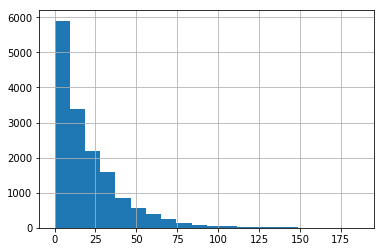

In [145]:
df_peps["Length"].hist(bins=20)

In [146]:
# so (not surprisingly) the typical length of a translated peptide from a random sequence is ~20 
# (since 3/64 ~ 1/20th of all translated codons are stop codons.
df_peps["Length"].describe()


count    15556.000000
mean        20.428002
std         20.849506
min          0.000000
25%          6.000000
50%         14.000000
75%         29.000000
max        186.000000
Name: Length, dtype: float64

# assignment (due next Thursday):
## think of a way (or look up) a way to produce a random sequence that has a higher GC content than the equal 25-25-25-25 that we have just analysed.
## hint: try googling stack-overflow.  also, what happens if "your_letters" has more than one copy of each DNA letter?
## specific question: "describe" the random translation of a string of 999999 letters with GC content of 0.667 = 2/3.

# return to our annotations, and now add the CDS and peptide to the table

In [214]:
annot.head(10)

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX
5,chr,NC_000913.3,5683,6459,-,944749,yaaA,b0006,NP_414547.1,258,-,peroxide stress resistance protein YaaA
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B
8,chr,NC_000913.3,9306,9893,+,944760,mog,b0009,NP_414550.1,195,-,molybdopterin adenylyltransferase
9,chr,NC_000913.3,9928,10494,-,944792,satP,b0010,NP_414551.1,188,-,acetate/succinate:H(+) symporter


In [213]:
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row = revcomp( genome[row["Start"]-1 : row["Stop"]] ) 
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

KeyError: 'GA'

In [ ]:
# we screwed up, presumably on the opposite strand
# add debugging

In [185]:
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row = genome[row["Stop"]-1 : row["Start"]] 
    print(index, row["Strand"], len(CDS_row))
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

0 + 66
1 + 2463
2 + 933
3 + 1287
4 + 297
5 - 0
6 - 0
7 + 954
8 + 588
9 - 0
10 - 0
11 + 486
12 - 0
13 + 1917
14 + 1131
15 + 1113
16 - 0
17 - 0
18 + 1167
19 + 906
20 - 0
21 - 0
22 - 0
23 + 219
24 + 942
25 + 2817
26 + 495
27 + 450
28 + 951
29 + 915
30 + 822
31 + 1149
32 + 3222
33 + 396
34 - 0
35 - 0
36 - 0
37 - 0
38 - 0
39 - 0
40 + 771
41 + 942
42 + 1287
43 + 288
44 + 1332
45 + 531
46 + 1863
47 + 480
48 - 0
49 - 0
50 - 0
51 - 0
52 - 0
53 - 0
54 + 816
55 + 651
56 + 159
57 - 0
58 - 0
59 - 0
60 - 0
61 - 0
62 - 0
63 + 879
64 + 765
65 - 0
66 - 0
67 - 0
68 - 0
69 + 132
70 + 1179
71 - 0
72 - 0
73 - 0
74 - 0
75 - 0
76 + 945
77 - 0
78 + 1725
79 + 492
80 + 1005
81 + 459
82 + 942
83 + 366
84 + 1767
85 + 1488
86 + 1359
87 + 1083
88 + 1317
89 + 1245
90 + 1068
91 + 1476
92 + 921
93 + 831
94 + 1263
95 + 1152
96 + 918
97 + 513
98 + 2706
99 + 390
100 - 0
101 - 0
102 - 0
103 + 45
104 + 1044
105 - 0
106 - 0
107 - 0
108 - 0
109 + 552
110 + 855
111 - 0
112 + 765
113 + 2664
114 + 1893
115 + 1425
116 - 0
117 + 

KeyError: 'GA'

In [154]:
annot.iloc[452]

#Replicon Name                                     chr
Replicon Accession                         NC_000913.3
Start                                           492092
Stop                                            493386
Strand                                               +
GeneID                                          945105
Locus                                             dnaX
Locus tag                                        b0470
Protein product                         YP_009518751.1
Length                                             431
COG(s)                                               -
Protein name          DNA polymerase III subunit gamma
Name: 452, dtype: object

In [155]:
# a plus strand!
493386-492092+1

1295

In [240]:
# this is not a multiple of three!  ERROR in the input file.
# we can look at this mroe carefully, but for now lets flag such problems
CDS = []
peptide = []
for index, row in annot.iterrows():
    if ( row["Strand"] == "+" ):
        CDS_row = genome[row["Start"]-1 : row["Stop"]]
    if ( row["Strand"] == "-" ):
        CDS_row_rev = genome[row["Start"]-1 : row["Stop"] : 1] 
        CDS_row =  revcomp( CDS_row_rev )
#   check for multiple of three. if not, make a dummy entry
    if ( len(CDS_row)%3 != 0):
        print(index, row["Strand"], len(CDS_row), row["Locus"])
        CDS_row = ''
    CDS.append( CDS_row )
    peptide.append( translate(CDS_row) )
annot["CDS"] = CDS
annot["peptide"] = peptide
annot.head(10)

452 + 1295 dnaX
467 - 212 copA
2800 - 1099 prfB


,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name,CDS,peptide
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG_
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,VKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...
5,chr,NC_000913.3,5683,6459,-,944749,yaaA,b0006,NP_414547.1,258,-,peroxide stress resistance protein YaaA,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ,ATGCCAGATTTTTTCTCCTTCATTAACAGCGTCCTTTGGGGATCGG...,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B,ATGACGGACAAATTGACCTCCCTTCGTCAGTACACCACCGTAGTGG...,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...
8,chr,NC_000913.3,9306,9893,+,944760,mog,b0009,NP_414550.1,195,-,molybdopterin adenylyltransferase,ATGAATACTTTACGTATTGGCTTAGTTTCCATCTCTGATCGCGCAT...,MNTLRIGLVSISDRASSGVYQDKGIPALEEWLTSALTTPFELETRL...
9,chr,NC_000913.3,9928,10494,-,944792,satP,b0010,NP_414551.1,188,-,acetate/succinate:H(+) symporter,ATGGGCAACACTAAGTTGGCTAATCCGGCACCGCTGGGCCTGATGG...,MGNTKLANPAPLGLMGFGMTTILLNLHNVGYFALDGIILAMGIFYG...


# codon usage and correlations (Feb 12)

In [316]:
keys = gencode.keys()
print(keys)

dict_keys(['ATA', 'ATC', 'ATT', 'ATG', 'ACA', 'ACC', 'ACG', 'ACT', 'AAC', 'AAT', 'AAA', 'AAG', 'AGC', 'AGT', 'AGA', 'AGG', 'CTA', 'CTC', 'CTG', 'CTT', 'CCA', 'CCC', 'CCG', 'CCT', 'CAC', 'CAT', 'CAA', 'CAG', 'CGA', 'CGC', 'CGG', 'CGT', 'GTA', 'GTC', 'GTG', 'GTT', 'GCA', 'GCC', 'GCG', 'GCT', 'GAC', 'GAT', 'GAA', 'GAG', 'GGA', 'GGC', 'GGG', 'GGT', 'TCA', 'TCC', 'TCG', 'TCT', 'TTC', 'TTT', 'TTA', 'TTG', 'TAC', 'TAT', 'TAA', 'TAG', 'TGC', 'TGT', 'TGA', 'TGG'])


In [318]:
values = list(gencode.values())
print(values)

['I', 'I', 'I', 'M', 'T', 'T', 'T', 'T', 'N', 'N', 'K', 'K', 'S', 'S', 'R', 'R', 'L', 'L', 'L', 'L', 'P', 'P', 'P', 'P', 'H', 'H', 'Q', 'Q', 'R', 'R', 'R', 'R', 'V', 'V', 'V', 'V', 'A', 'A', 'A', 'A', 'D', 'D', 'E', 'E', 'G', 'G', 'G', 'G', 'S', 'S', 'S', 'S', 'F', 'F', 'L', 'L', 'Y', 'Y', '_', '_', 'C', 'C', '_', 'W']


In [323]:
# remove redundancy (note how "set' works)
# sort alphanumerically
amino_acids = sorted(list(set(values)))
print(amino_acids)

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '_']


In [236]:
# function: given a cds, count occurrences of each codon
def codon_counts(CDS):
    keys = gencode.keys()
    count_dict = {}
    for key in keys:
        count_dict[key] = 0
    for j in range(0,len(CDS),3):
        codon = CDS[j:j+3]
        count_dict[codon] += 1
    return count_dict

In [314]:
print(keys)

dict_keys(['ATA', 'ATC', 'ATT', 'ATG', 'ACA', 'ACC', 'ACG', 'ACT', 'AAC', 'AAT', 'AAA', 'AAG', 'AGC', 'AGT', 'AGA', 'AGG', 'CTA', 'CTC', 'CTG', 'CTT', 'CCA', 'CCC', 'CCG', 'CCT', 'CAC', 'CAT', 'CAA', 'CAG', 'CGA', 'CGC', 'CGG', 'CGT', 'GTA', 'GTC', 'GTG', 'GTT', 'GCA', 'GCC', 'GCG', 'GCT', 'GAC', 'GAT', 'GAA', 'GAG', 'GGA', 'GGC', 'GGG', 'GGT', 'TCA', 'TCC', 'TCG', 'TCT', 'TTC', 'TTT', 'TTA', 'TTG', 'TAC', 'TAT', 'TAA', 'TAG', 'TGC', 'TGT', 'TGA', 'TGG'])


In [231]:
CDS[3]

'ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTGCGCAAGCCGTAACCCAGGGGTTGGGCAAAAATCAGGGGCTGTTTTTTCCGCACGACCTGCCGGAATTCAGCCTGACTGAAATTGATGAGATGCTGAAGCTGGATTTTGTCACCCGCAGTGCGAAGATCCTCTCGGCGTTTATTGGTGATGAAATCCCACAGGAAATCCTGGAAGAGCGCGTGCGCGCGGCGTTTGCCTTCCCGGCTCCGGTCGCCAATGTTGAAAGCGATGTCGGTTGTCTGGAATTGTTCCACGGGCCAACGCTGGCATTTAAAGATTTCGGCGGTCGCTTTATGGCACAAATGCTGACCCATATTGCGGGTGATAAGCCAGTGACCATTCTGACCGCGACCTCCGGTGATACCGGAGCGGCAGTGGCTCATGCTTTCTACGGTTTACCGAATGTGAAAGTGGTTATCCTCTATCCACGAGGCAAAATCAGTCCACTGCAAGAAAAACTGTTCTGTACATTGGGCGGCAATATCGAAACTGTTGCCATCGACGGCGATTTCGATGCCTGTCAGGCGCTGGTGAAGCAGGCGTTTGATGATGAAGAACTGAAAGTGGCGCTAGGGTTAAACTCGGCTAACTCGATTAACATCAGCCGTTTGCTGGCGCAGATTTGCTACTACTTTGAAGCTGTTGCGCAGCTGCCGCAGGAGACGCGCAACCAGCTGGTTGTCTCGGTGCCAAGCGGAAACTTCGGCGATTTGACGGCGGGTCTGCTGGCGAAGTCACTCGGTCTGCCGGTGAAACGTTTTATTGCTGCGACCAACGTGAACGATACCGTGCCACGTTTCCTGCACGACGGTCAGTGGTCACCCAAAGCGACTCAGGCGACGTTATCCAACGCGATGGACGTGAGTCAGCCGAACAACTGGCCGCGTGTGGAAGAGTTGTTCCGCCGCAAAATCTGGCAACTGAAAGAGCTGGGTTATGCAGCCGTGGATGAT

In [237]:
codon_counts(CDS[3])

{'AAA': 17,
 'AAC': 11,
 'AAG': 5,
 'AAT': 8,
 'ACA': 2,
 'ACC': 11,
 'ACG': 6,
 'ACT': 4,
 'AGA': 0,
 'AGC': 6,
 'AGG': 0,
 'AGT': 3,
 'ATA': 0,
 'ATC': 9,
 'ATG': 8,
 'ATT': 8,
 'CAA': 5,
 'CAC': 5,
 'CAG': 16,
 'CAT': 5,
 'CCA': 9,
 'CCC': 3,
 'CCG': 11,
 'CCT': 0,
 'CGA': 1,
 'CGC': 7,
 'CGG': 0,
 'CGT': 9,
 'CTA': 1,
 'CTC': 6,
 'CTG': 29,
 'CTT': 1,
 'GAA': 19,
 'GAC': 4,
 'GAG': 10,
 'GAT': 20,
 'GCA': 5,
 'GCC': 8,
 'GCG': 24,
 'GCT': 10,
 'GGA': 2,
 'GGC': 11,
 'GGG': 4,
 'GGT': 11,
 'GTA': 2,
 'GTC': 5,
 'GTG': 15,
 'GTT': 5,
 'TAA': 1,
 'TAC': 5,
 'TAG': 0,
 'TAT': 4,
 'TCA': 3,
 'TCC': 2,
 'TCG': 5,
 'TCT': 0,
 'TGA': 0,
 'TGC': 1,
 'TGG': 3,
 'TGT': 3,
 'TTA': 5,
 'TTC': 11,
 'TTG': 12,
 'TTT': 13}

In [239]:
annot.head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX


In [ ]:
# codon usage

In [244]:
keys = gencode.keys()
total_count_dict = {}
for key in keys:
    total_count_dict[key] = [gencode[key],0]
    
for index, row in annot.iterrows():
    CDS = row["CDS"]
    for j in range(0,len(CDS),3):
        codon = CDS[j:j+3]
        total_count_dict[codon][1] += 1

In [245]:
total_count_dict

{'AAA': ['K', 44675],
 'AAC': ['N', 28572],
 'AAG': ['K', 13555],
 'AAT': ['N', 23070],
 'ACA': ['T', 9127],
 'ACC': ['T', 31194],
 'ACG': ['T', 19118],
 'ACT': ['T', 11708],
 'AGA': ['R', 2576],
 'AGC': ['S', 21319],
 'AGG': ['R', 1420],
 'AGT': ['S', 11492],
 'ATA': ['I', 5485],
 'ATC': ['I', 33575],
 'ATG': ['M', 37054],
 'ATT': ['I', 40539],
 'CAA': ['Q', 20413],
 'CAC': ['H', 12918],
 'CAG': ['Q', 38436],
 'CAT': ['H', 17114],
 'CCA': ['P', 11181],
 'CCC': ['P', 7241],
 'CCG': ['P', 31141],
 'CCT': ['P', 9233],
 'CGA': ['R', 4616],
 'CGC': ['R', 29471],
 'CGG': ['R', 7082],
 'CGT': ['R', 28020],
 'CTA': ['L', 5150],
 'CTC': ['L', 14824],
 'CTG': ['L', 70801],
 'CTT': ['L', 14582],
 'GAA': ['E', 52731],
 'GAC': ['D', 25376],
 'GAG': ['E', 23687],
 'GAT': ['D', 42508],
 'GCA': ['A', 26771],
 'GCC': ['A', 34161],
 'GCG': ['A', 45156],
 'GCT': ['A', 20216],
 'GGA': ['G', 10357],
 'GGC': ['G', 39611],
 'GGG': ['G', 14593],
 'GGT': ['G', 32865],
 'GTA': ['V', 14445],
 'GTC': ['V', 20381

In [243]:
# give some image here

{'AAA': 'K',
 'AAC': 'N',
 'AAG': 'K',
 'AAT': 'N',
 'ACA': 'T',
 'ACC': 'T',
 'ACG': 'T',
 'ACT': 'T',
 'AGA': 'R',
 'AGC': 'S',
 'AGG': 'R',
 'AGT': 'S',
 'ATA': 'I',
 'ATC': 'I',
 'ATG': 'M',
 'ATT': 'I',
 'CAA': 'Q',
 'CAC': 'H',
 'CAG': 'Q',
 'CAT': 'H',
 'CCA': 'P',
 'CCC': 'P',
 'CCG': 'P',
 'CCT': 'P',
 'CGA': 'R',
 'CGC': 'R',
 'CGG': 'R',
 'CGT': 'R',
 'CTA': 'L',
 'CTC': 'L',
 'CTG': 'L',
 'CTT': 'L',
 'GAA': 'E',
 'GAC': 'D',
 'GAG': 'E',
 'GAT': 'D',
 'GCA': 'A',
 'GCC': 'A',
 'GCG': 'A',
 'GCT': 'A',
 'GGA': 'G',
 'GGC': 'G',
 'GGG': 'G',
 'GGT': 'G',
 'GTA': 'V',
 'GTC': 'V',
 'GTG': 'V',
 'GTT': 'V',
 'TAA': '_',
 'TAC': 'Y',
 'TAG': '_',
 'TAT': 'Y',
 'TCA': 'S',
 'TCC': 'S',
 'TCG': 'S',
 'TCT': 'S',
 'TGA': '_',
 'TGC': 'C',
 'TGG': 'W',
 'TGT': 'C',
 'TTA': 'L',
 'TTC': 'F',
 'TTG': 'L',
 'TTT': 'F'}

# dendrogram with heat map
# https://python-graph-gallery.com/404-dendrogram-with-heat-map/

In [324]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt


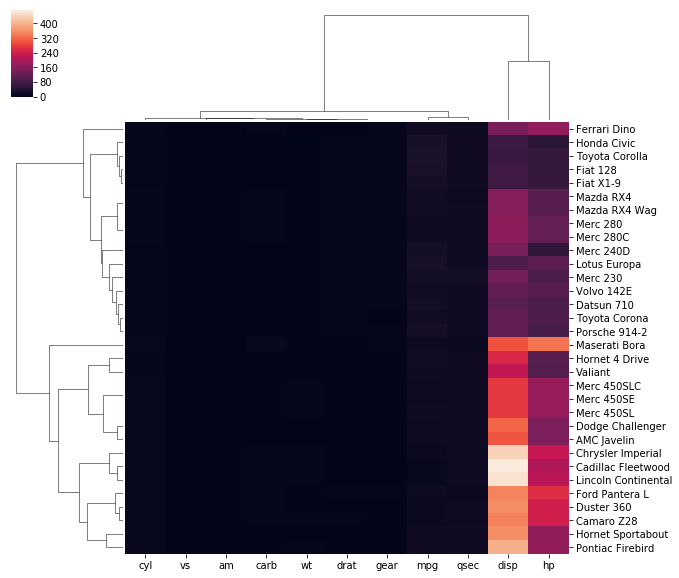

In [325]:
# Data set
url = 'https://python-graph-gallery.com/wp-content/uploads/mtcars.csv'
df = pd.read_csv(url)
df = df.set_index('model')
del df.index.name
df
 
# Default plot
sns.clustermap(df)


In [328]:
df.index

Index(['Mazda RX4', 'Mazda RX4 Wag', 'Datsun 710', 'Hornet 4 Drive',
       'Hornet Sportabout', 'Valiant', 'Duster 360', 'Merc 240D', 'Merc 230',
       'Merc 280', 'Merc 280C', 'Merc 450SE', 'Merc 450SL', 'Merc 450SLC',
       'Cadillac Fleetwood', 'Lincoln Continental', 'Chrysler Imperial',
       'Fiat 128', 'Honda Civic', 'Toyota Corolla', 'Toyota Corona',
       'Dodge Challenger', 'AMC Javelin', 'Camaro Z28', 'Pontiac Firebird',
       'Fiat X1-9', 'Porsche 914-2', 'Lotus Europa', 'Ford Pantera L',
       'Ferrari Dino', 'Maserati Bora', 'Volvo 142E'],
      dtype='object')

In [330]:
df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [331]:
# correlation of consecutive amino acids
import numpy
adjacency = numpy.zeros([21,21])

In [332]:
print(adjacency)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [334]:
annot.head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name,CDS,peptide
0,chr,NC_000913.3,190,255,+,944742,thrL,b0001,NP_414542.1,21,-,thr operon leader peptide,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,MKRISTTITTTITITTGNGAG_
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...
4,chr,NC_000913.3,5234,5530,+,944747,yaaX,b0005,NP_414546.1,98,-,DUF2502 domain-containing protein YaaX,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,VKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...


In [338]:
amino_acids

['A',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y',
 '_']

# count amino acid occurrences

In [426]:
# use aa's as a key
aa_count = dict()
for index, row in annot.iterrows():
    pep = row["peptide"]
    for j in range(0,len(pep)):
        aa = pep[j]
        if aa in aa_count.keys():
            aa_count[aa] += 1
        else:
            aa_count[aa] = 1

In [430]:
aa_counts_df = pd.DataFrame.from_dict(aa_count, orient="index")
aa_counts_df = aa_counts_df.rename(columns = {0:"count"})
aa_counts_df

,count
M,37054
K,58230
R,73185
I,79599
S,76505
T,71147
G,97426
N,51642
A,126304
_,4242


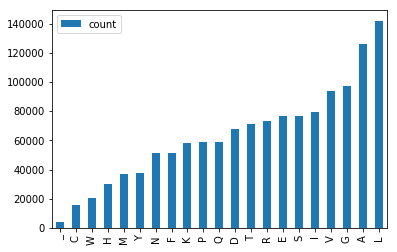

In [434]:
aa_counts_df.sort_values("count").plot(kind="bar")

In [443]:
tot = aa_counts_df.sum()
print(tot)

count    1328058
dtype: int64


In [445]:
aa_counts_df.describe()

,count
count,21.000000
mean,63240.857143
std,34262.537907
min,4242.000000
25%,37488.000000
50%,58849.000000
75%,76505.000000
max,141849.000000


In [447]:
aa_counts_df.head()

,count
M,37054
K,58230
R,73185
I,79599
S,76505


In [449]:
# add a frequency column
aa_counts_df['freq']= aa_counts_df['count'].apply(lambda x: x/tot) #["freq"] = aa_counts_df["count"]/1328058 )
aa_counts_df.head()

,count,freq
M,37054,0.027901
K,58230,0.043846
R,73185,0.055107
I,79599,0.059936
S,76505,0.057607


In [454]:
aa_counts_df.loc["M"]["freq"]

0.027900889870773715

# count consecutive pairs of aa's

In [435]:
# use tuple of aa's as a key
aa_adjacency = dict()
for index, row in annot.iterrows():
    pep = row["peptide"]
    for j in range(0,len(pep)-1):
        aa1 = pep[j]
        aa2 = pep[j+1]
        aa_tup = (aa1,aa2)
        if aa_tup in aa_adjacency.keys():
            aa_adjacency[aa_tup] += 1
        else:
            aa_adjacency[aa_tup] = 1

In [436]:
# turn into a data frame
pd.DataFrame.from_dict(aa_adjacency,orient="index").head()

,0
"(M, K)",1859
"(K, R)",3470
"(R, I)",4426
"(I, S)",5299
"(S, T)",3940


In [437]:
# turn into a data frame (there are fancier ways
aa_adjacency_df = pd.DataFrame(index = amino_acids, columns = amino_acids)
for (aa1,aa2) in aa_adjacency.keys():
    aa_adjacency_df.loc[aa1,aa2] = aa_adjacency[(aa1,aa2)]
aa_adjacency_df = aa_adjacency_df.fillna(0)
aa_adjacency_df.tail()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,_
T,6710,740,3493,3478,2824,5963,1650,4098,2075,9596,...,2186,4224,2887,3953,3831,3970,5202,1122,1560,44
V,9281,1113,5005,5465,3423,6455,1694,6378,4356,9581,...,3820,4016,3084,4705,5875,5674,7577,1301,2322,200
W,1367,273,832,776,952,1244,604,1030,724,3111,...,640,861,1720,1425,1106,766,1261,327,610,61
Y,3236,527,2073,1771,1607,2933,995,1969,1343,4018,...,1394,1811,2086,2415,2363,2003,2221,585,1298,98
_,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [439]:
# strip off last row (no pairs start with STOP)
aa_adjacency_df = aa_adjacency_df.loc[amino_acids[0:20]]

In [440]:
aa_adjacency_df.shape

(20, 21)

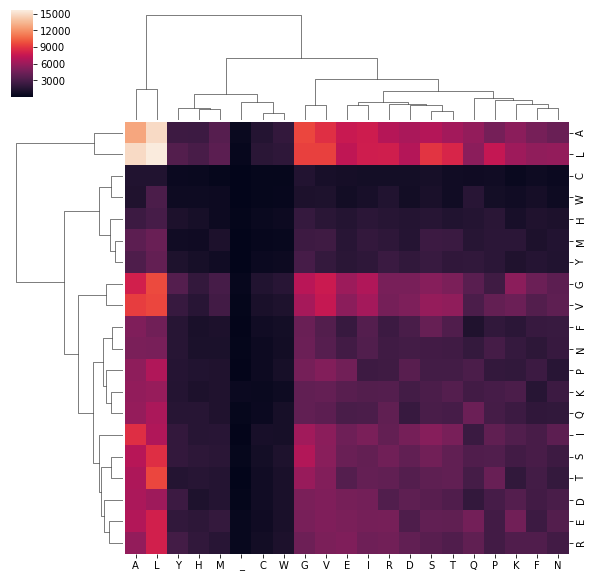

In [441]:
sns.clustermap(aa_adjacency_df)

In [ ]:
# this is the raw data (counts) and is dominated by the commonality of L, A 
# and scarcity of Y,H,M, C, and W _ (one per gene) 

In [416]:
# turn into a data frame -- normalized
aa_adjacency_df2 = pd.DataFrame(index = amino_acids, columns = amino_acids)
for (aa1,aa2) in aa_adjacency.keys():
    aa_adjacency_df2.loc[aa1,aa2] = 10000000 * aa_adjacency[(aa1,aa2)]/(aa_count[aa1]*aa_count[aa2])
aa_adjacency_df2 = aa_adjacency_df2.fillna(0)
# drop the line with '-' (since there are no tuples that start with '_')
aa_adjacency_df2 = aa_adjacency_df2.loc[amino_acids[0:20]]

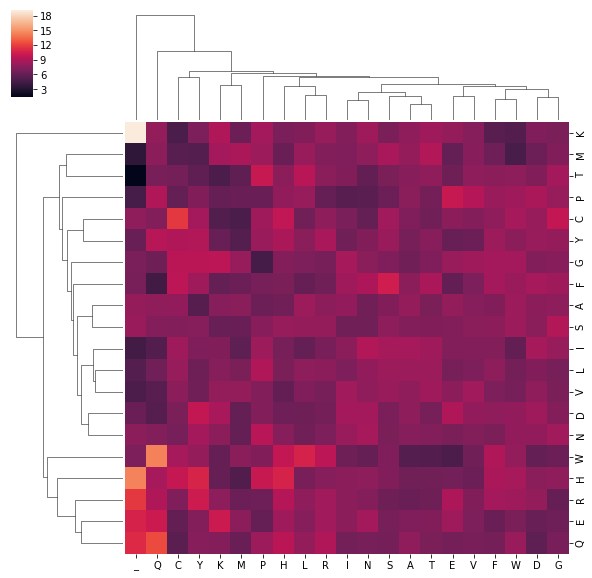

In [450]:
sns.clustermap(aa_adjacency_df2)

In [460]:
# turn into a data frame -- normalized a different way
aa_adjacency_df3 = pd.DataFrame(index = amino_acids, columns = amino_acids)
for (aa1,aa2) in aa_adjacency.keys():
    aa_adjacency_df3.loc[aa1,aa2] = aa_adjacency[(aa1,aa2)] - aa_count[aa1]*aa_counts_df.loc[aa2]["freq"]
aa_adjacency_df3 = aa_adjacency_df3.fillna(0)
# drop the line with '-' (since there are no tuples that start with '_')
aa_adjacency_df3 = aa_adjacency_df3.loc[amino_acids[0:20]]

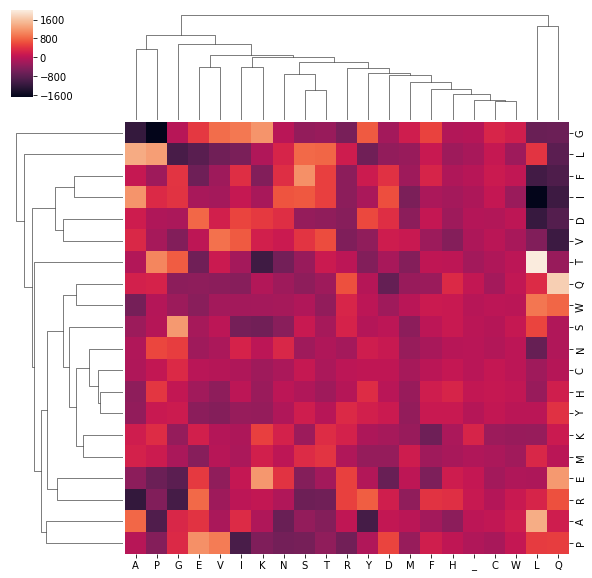

In [461]:
sns.clustermap(aa_adjacency_df3)

In [464]:
# turn into a data frame -- normalized a different way
aa_adjacency_df4 = pd.DataFrame(index = amino_acids, columns = amino_acids)
for (aa1,aa2) in aa_adjacency.keys():
    aa_adjacency_df4.loc[aa1,aa2] = (aa_adjacency[(aa1,aa2)] - aa_count[aa1]*aa_counts_df.loc[aa2]["freq"])/(aa_count[aa1]*aa_counts_df.loc[aa2]["freq"])
aa_adjacency_df4 = aa_adjacency_df4.fillna(0)
# drop the line with '-' (since there are no tuples that start with '_')
aa_adjacency_df4 = aa_adjacency_df4.loc[amino_acids[0:20]]

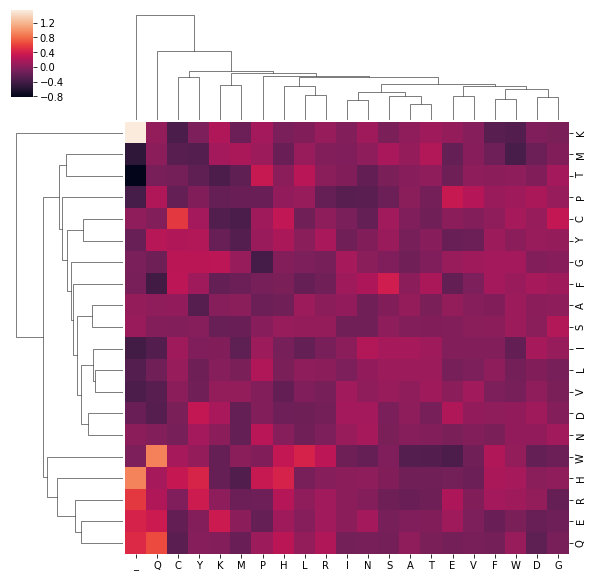

In [465]:
sns.clustermap(aa_adjacency_df4)

In [40]:
nucleotides = ['A','C','G','T']

In [296]:
# add on to a given list
def tack_on(list1, alphabet):
    list2 = []
    for i in list1:
        for j in alphabet:
            list2.append(i+j)
    return list2

In [297]:
# test it!
listN = nucleotides
tack_on(listN, nucleotides)

['AA',
 'AC',
 'AG',
 'AT',
 'CA',
 'CC',
 'CG',
 'CT',
 'GA',
 'GC',
 'GG',
 'GT',
 'TA',
 'TC',
 'TG',
 'TT']

In [298]:
print(listN)

['A', 'C', 'G', 'T']


In [299]:
list2 = tack_on(listN, nucleotides)

In [300]:
print(list2)

['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT', 'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']


In [ ]:
#iterate

In [ ]:
# six frame translation
# given a 

In [337]:
annot[annot.Length > 300].head()

,#Replicon Name,Replicon Accession,Start,Stop,Strand,GeneID,Locus,Locus tag,Protein product,Length,COG(s),Protein name,CDS,peptide
1,chr,NC_000913.3,337,2799,+,945803,thrA,b0002,NP_414543.1,820,-,fused aspartate kinase/homoserine dehydrogenase 1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
2,chr,NC_000913.3,2801,3733,+,947498,thrB,b0003,NP_414544.1,310,-,homoserine kinase,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...
3,chr,NC_000913.3,3734,5020,+,945198,thrC,b0004,NP_414545.1,428,-,threonine synthase,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...
6,chr,NC_000913.3,6529,7959,-,944745,yaaJ,b0007,NP_414548.1,476,-,putative transporter YaaJ,ATGCCAGATTTTTTCTCCTTCATTAACAGCGTCCTTTGGGGATCGG...,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...
7,chr,NC_000913.3,8238,9191,+,944748,talB,b0008,NP_414549.1,317,-,transaldolase B,ATGACGGACAAATTGACCTCCCTTCGTCAGTACACCACCGTAGTGG...,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...
